# Exploring the CIA Factbook <font style='color:rgb(0,100,200)'> (Work In Progress) </font>

In this project we explore the Central Intelligence Agency (CIA) World Factbook, a compendium of statistics about all countries on Earth. 
The database, `factbook.db`, was downloaded from [this GitHub repository](https://github.com/factbook) in January 2020. 
It was released on 1 November 2015 and has (as of 05 January 2020) never been updated. 
More information on the Factbook can be found on [“The World Factbook” Wikipedia page](https://en.wikipedia.org/wiki/The_World_Factbook). 

## Interfacing SQL with Pandas

We will access information in the database using SQL queries, and analyse it using the Pandas library. 
To this end, we will define a connection `conn` to the database and a function `SQL_to_pandas` taking an SQL query and returning its result in a Pandas dataframe. 
First, we import the relevent packages:

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

We then define the connectin and `SQL_to_pandas` function:

In [2]:
conn = sqlite3.connect('../Data/factbook.db')
def SQL_to_pandas(query):
    '''
    Takes an SQL query and returns its results as a Pandas dataframe.
    query: string
    '''
    df = pd.read_sql_query(query, conn)
    return df

# Data exploration

To see what is in the database, let us print information on the tables it contains:

In [3]:
SQL_to_pandas('SELECT * FROM sqlite_master WHERE type="table"')

,type,name,tbl_name,rootpage,sql
0,table,facts,facts,2,"CREATE TABLE ""facts"" (""id"" INTEGER PRIMARY KEY..."
1,table,sqlite_sequence,sqlite_sequence,3,"CREATE TABLE sqlite_sequence(name,seq)"


The database contains two tables: `facts` and `sqlite_sequence`. 
Let us print the 5 first rows of the former:

In [4]:
SQL_to_pandas('SELECT * FROM facts LIMIT 5')

,id,code,name,area,area_land,area_water,population,population_growth,birth_rate,death_rate,migration_rate,created_at,updated_at
0,1,af,Afghanistan,652230,652230,0,32564342,2.32,38.57,13.89,1.51,2015-11-01 13:19:49.461734,2015-11-01 13:19:49.461734
1,2,al,Albania,28748,27398,1350,3029278,0.30,12.92,6.58,3.30,2015-11-01 13:19:54.431082,2015-11-01 13:19:54.431082
2,3,ag,Algeria,2381741,2381741,0,39542166,1.84,23.67,4.31,0.92,2015-11-01 13:19:59.961286,2015-11-01 13:19:59.961286
3,4,an,Andorra,468,468,0,85580,0.12,8.13,6.96,0.00,2015-11-01 13:20:03.659945,2015-11-01 13:20:03.659945
4,5,ao,Angola,1246700,1246700,0,19625353,2.78,38.78,11.49,0.46,2015-11-01 13:20:08.625072,2015-11-01 13:20:08.625072


It contains 13 columns: 
* `Id`: an integer given to each country, which seem to be listed in alphabetical order,
* `code`: an appparently two-letter code for each country, 
* `name`: the country name,
* `area`: the total area in square kilometers, 
* `area_land`: the area covered by land in square kilometers,
* `area_water`: the area covered by water in square kilometers, 
* `population`: the total population, 
* `population_growth`: annual population growth as a percentage,
* `birth_rate`: the birth rate (number of births a year per 1000 people),
* `death_rate`: the death rate (number of deatth a year per 1000 people),
* `migration_rate`: the migration rate,
* `created_at`: the date and time when the entry was added (in year-month-day time format),
* `updated_at`: the date and time when the entry was last updated (in year-month-day time format).

Let us print the other table:

In [5]:
SQL_to_pandas('SELECT * FROM sqlite_sequence')

,name,seq
0,facts,261


This table contains only the number of rows in the other one.

Let us focus on the populations and their variations. 
The following query prints the minima and maxima of the populations and their growths.

In [6]:
SQL_to_pandas('''
SELECT 
    MIN(population) AS "Lowest Population", 
    MAX(population) AS "Highest Population",
    MIN(population_growth) AS "Lowest Population Growth", 
    MAX(population_growth) AS "Highest Population Growth"
FROM facts
''').style.hide_index() # hide the index for readability

Lowest Population,Highest Population,Lowest Population Growth,Highest Population Growth
0,7256490011,0,4.02


There seems to be two issues: 
* The lowest population is 0, which looks strange.
* The highest population is larger that 7 billions, which looks like the total world population. 

To see what is going on, let us print the names of entries with lowest and highest populations:

In [7]:
SQL_to_pandas('''
SELECT * FROM facts WHERE population IN
    ((SELECT MIN(population) FROM facts), 
    (SELECT MAX(population) FROM facts))
''').style.hide_index()

id,code,name,area,area_land,area_water,population,population_growth,birth_rate,death_rate,migration_rate,created_at,updated_at
250,ay,Antarctica,None,280000,None,0,nan,nan,nan,None,2015-11-01 13:38:44.885746,2015-11-01 13:38:44.885746
261,xx,World,None,nan,None,7256490011,1.08,18.6,7.8,None,2015-11-01 13:39:09.910721,2015-11-01 13:39:09.910721


There is one country with no population at all: Antartica. 
The highest reported population is that of the entire world. 

Let us now show histograms for the population, population growth, birth rate, and death rate, excluding these two particular entries:

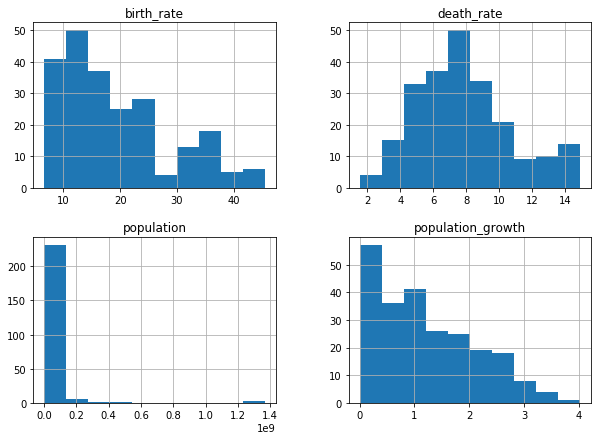

In [8]:
pop_birth_death = SQL_to_pandas('''
SELECT population, population_growth, birth_rate, death_rate
FROM facts
WHERE  name NOT IN ("Antartica","World")
''')
pop_birth_death.hist(figsize=(10,7))
plt.show()

We notice that a large majority of countries have less than 200 million inhabitants, while a few outliers have more than one billion. 
Let us remove look at the population distribution without these outliers:

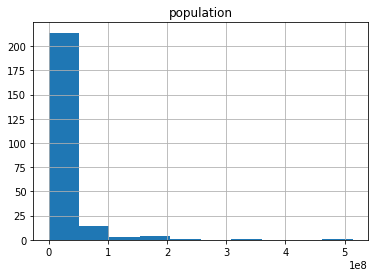

In [9]:
pop_no_outl = SQL_to_pandas('''
SELECT population
FROM facts
WHERE population < 1000000000
    AND population > 0
''')
pop_no_outl.hist()
plt.show()

Most countries seem to have less than 50,000,000 inhabitants. 
Let us focus on them:

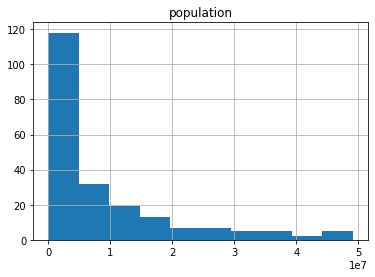

In [10]:
pop_small = SQL_to_pandas('''
SELECT population
FROM facts
WHERE population < 50000000
    AND population > 0
''')
pop_small.hist()
plt.show()

Given that the difference between highest and lowest populations spans orders of magnitudes, it may be more instructive to look at the logarithm of the population instead:

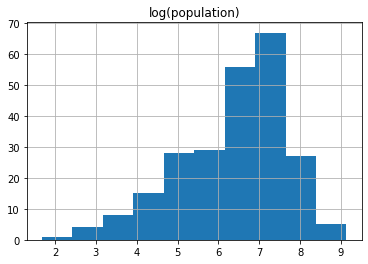

In [11]:
pop_log = SQL_to_pandas('''
SELECT population
FROM facts
WHERE name != "World"
    AND population > 0
''')
pop_log['log(population)'] = np.log(pop_log['population'])/np.log(10)
pop_log.drop('population', axis=1, inplace=True)
pop_log.hist()
plt.show()

Let us now focus on the population density. 

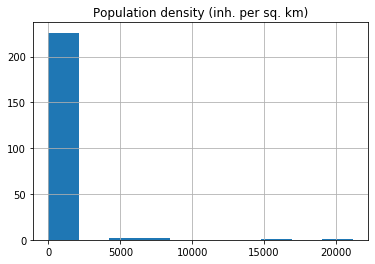

In [23]:
pop_density = SQL_to_pandas('''
SELECT name, CAST(population AS FLOAT) / area_land AS density
FROM facts
WHERE name != "World"
    AND population > 0
''')
pop_density.hist()
plt.title('Population density (inh. per sq. km)')
plt.show()

Most countries seem to have a density smaller than 2000 inhabitants per square kilometers, while a few have more. 
Let us see which countries have such a high density:

In [24]:
pop_density[pop_density['density'] > 2000].sort_values('density', ascending = False).style.hide_index()

name,density
Macau,21169
Monaco,15267.5
Singapore,8259.78
Hong Kong,6655.27
Gaza Strip,5191.82
Gibraltar,4876.33


Six countries have such a high population density. 
The country with highest density is Macau, followed by Monaco and Singapore. 

Let us now look at the countries with smallest densities:

In [25]:
pop_density.sort_values('density')[:5].style.hide_index()

name,density
Greenland,0.0266531
Svalbard,0.0301716
Falkland Islands (Islas Malvinas),0.276103
Pitcairn Islands,1.02128
Mongolia,1.92649


Greenland, the Falkland Islands, and Svalbard have a density inferior to 1 inhabitant per square kilometer. 

As we did for the population, let us plot an histogram the logarithm of the density:

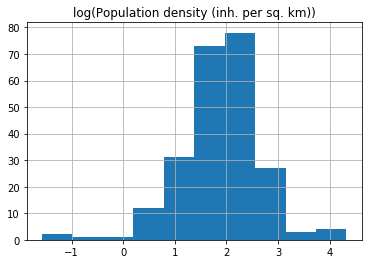

In [29]:
pop_density_log = SQL_to_pandas('''
SELECT name, CAST(population AS FLOAT) / area_land AS density
FROM facts
WHERE name != "World"
    AND population > 0
''')
pop_density_log['density_log'] = np.log(pop_density_log['density'])/np.log(10)
pop_density_log.drop('density', axis=1, inplace=True)
pop_density_log.hist()
plt.title('log(Population density (inh. per sq. km))')
plt.show()

Finally, let us focus on the ratio of water to land:

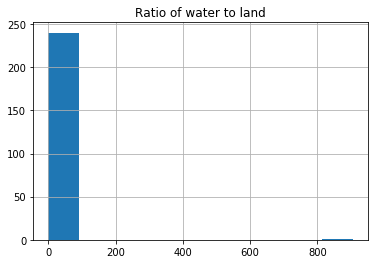

In [41]:
wat_to_lan = SQL_to_pandas('''
SELECT name, CAST(area_water AS FLOAT) / area_land AS water_to_land
FROM facts
WHERE name != "World"
''')
wat_to_lan.hist()
plt.title('Ratio of water to land')
plt.show()

There is one outlier with more than 800 times more water than land. 
Let us see which country it is:

In [42]:
wat_to_lan.sort_values('water_to_land', ascending=False)[:1].style.hide_index()

name,water_to_land
British Indian Ocean Territory,905.667


The British Indian Ocean Territory is made mostly of water. 

Let us redraw the histogram without this outlier:

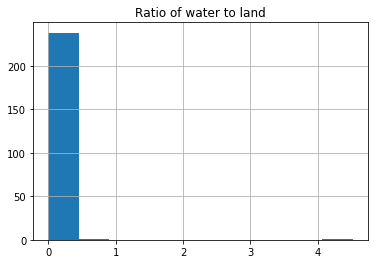

In [43]:
wat_to_lan_2 = SQL_to_pandas('''
SELECT name, CAST(area_water AS FLOAT) / area_land AS water_to_land
FROM facts
WHERE name != "World"
    AND water_to_land < 900
''')
wat_to_lan_2.hist()
plt.title('Ratio of water to land')
plt.show()

There is another outlier.

In [44]:
wat_to_lan_2.sort_values('water_to_land', ascending=False)[:1].style.hide_index()

name,water_to_land
Virgin Islands,4.52023


This country is the Virgin Islands, with more than 4 times as much water as lands.

Let us redraw the histogram without this second outlier:

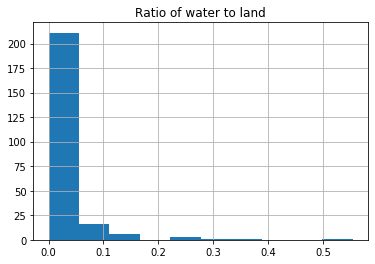

In [45]:
wat_to_lan_3 = SQL_to_pandas('''
SELECT name, CAST(area_water AS FLOAT) / area_land AS water_to_land
FROM facts
WHERE name != "World"
    AND water_to_land < 4
''')
wat_to_lan_3.hist()
plt.title('Ratio of water to land')
plt.show()

Most cuntries have more than 10 times as much land as they have water. 
It seems the British Indian Ocean Territory and Virgin Islands are the only countries with more water than land.
Let us check this:

In [46]:
SQL_to_pandas('''
SELECT name, CAST(area_water AS FLOAT) / area_land AS water_to_land
FROM facts
WHERE water_to_land >= 1
''')

,name,water_to_land
0,British Indian Ocean Territory,905.666667
1,Virgin Islands,4.520231


They are indeed the only two. 

Finally, let us see how many countries have no water area at all:

In [48]:
SQL_to_pandas('''
SELECT COUNT(*)
FROM facts
WHERE area_water = 0
''')

,COUNT(*)
0,90


There are 90 countries with no water area at all.